## Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import time

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import *
from time import *

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/ProjectPemsu/JSON/Hasil_Ekstraksi_Fitur.json"
SAVED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ProjectPemsu/JSON/Model_ANN.h5"
EPOCHS = 16
BATCH_SIZE = 32
PATIENCE = 10
LEARNING_RATE = 0.0001

## Load Data JSON

In [3]:
def load_data(data_path):

    # load training dataset from json file
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
        X = np.array(data["mfcc"])
        y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

## Split Data

In [4]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.1):

    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42, stratify=y)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, shuffle=True, random_state=42, stratify=y_train)


    print("Jumlah data training :", round(len(X_train)/len(X)*100), "%")
    print("Jumlah data test :", round(len(X_test)/len(X)*100), "%")
    print("Jumlah data validation :", round(len(X_validation)/len(X)*100), "%\n")

    return X_train, y_train, X_validation, y_validation, X_test, y_test

## Model ANN

In [5]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):

    # build network architecture layers
    model = tf.keras.Sequential([
        # input layer
        tf.keras.layers.Flatten(input_shape=input_shape),
        # 1st dense layer
        tf.keras.layers.Dense(512, activation='relu'),
        # 2nd dense layer
        tf.keras.layers.Dense(256, activation='relu'),
        # 3rd dense layer
        tf.keras.layers.Dense(128, activation='relu'),
        # 4rd dense layer
        tf.keras.layers.Dense(64, activation='relu'),
        # 5rd dense layer
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        # output layer
        tf.keras.layers.Dense(2, activation='softmax') # Jawa and madura
    ])

    # compile model
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    return model

## Proses Training

In [6]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.1, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])

    return history

## Pembuatan Grafik Akurasi dan Loss terhadap Jumlah Epoch

In [7]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    fig.tight_layout()
    plt.show()

## Fungsi Prediksi dan Confusion Matrix

In [8]:
def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Data Asli: {}, Hasil Prediksi: {}".format(y, predicted_index))

In [9]:
def confusionMatrix(model, X_test, y_test):

  pred = model.predict(X_test)
  y_pred = []
  for i in pred:
      y_pred.append(np.argmax(i))

  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Jawa', 'Madura'])
  cm_display.plot()
  cm_display.ax_.set_title("Confusion Matrix")
  plt.show()

  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  F1 = f1_score(y_test, y_pred)

  print("Accuracy :", accuracy*100, " %")
  print("Recall :", recall*100, " %")
  print("Precision :", precision*100, " %")
  print("F1-Score :", F1*100, " %")

## Fungsi Main Program

In [10]:
def main():
    # # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    # train network and calculate computation time
    start_time = time.time()
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    end_time = time.time()

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, \nTest accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    model.save(SAVED_MODEL_PATH)

    # Uji Prediksi
    for _ in range(20):
        r = random.randint(0,100)
        X_to_predict = X_test[r]
        y_to_predict = y_test[r]

        predict(model, X_to_predict, y_to_predict)
    #Visualisasikan hasil Prediksi dan Akurasi
    confusionMatrix(model, X_test, y_test)

    print("Waktu Mulai Komputasi:", start_time)
    print("Waktu Akhir Komputasi:", end_time)
    print("Total Waktu Komputasi:", end_time - start_time)

Data succesfully loaded!
Jumlah data training : 72 %
Jumlah data test : 20 %
Jumlah data validation : 8 %

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5603)              0         
                                                                 
 dense (Dense)               (None, 512)               2869248   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
               

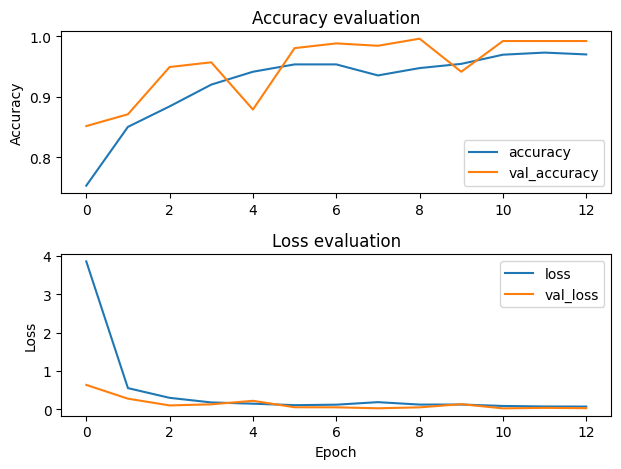

20/20 [==============================] - 0s 6ms/step - loss: 0.0722 - accuracy: 0.9891

Test loss: 0.07220597565174103, 
Test accuracy: 98.9062488079071


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 99ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 29ms/step
Data Asli: 0, Hasil Prediksi: [0]
1/1 [==============================] - 0s 29ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 23ms/step
Data Asli: 0, Hasil Prediksi: [0]
1/1 [==============================] - 0s 23ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 27ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 23ms/step
Data Asli: 0, Hasil Prediksi: [0]
1/1 [==============================] - 0s 25ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 31ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 22ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 25ms/step
Data Asli: 1, Hasil Prediksi: [1]
1/1 [==============================] - 0s 25ms/step
Da

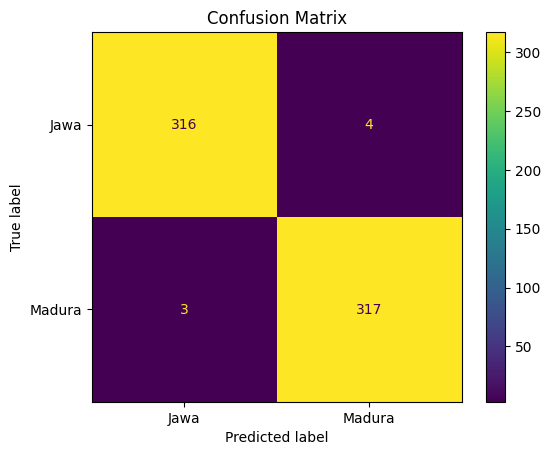

Accuracy : 98.90625  %
Recall : 99.0625  %
Precision : 98.75389408099689  %
F1-Score : 98.90795631825272  %
Waktu Mulai Komputasi: 1700669315.111941
Waktu Akhir Komputasi: 1700669341.7625191
Total Waktu Komputasi: 26.650578022003174


In [11]:
import time

if __name__ == "__main__":
    main()